<a href="https://colab.research.google.com/github/andreidm92/computer_vision_tasks/blob/main/practice/Lesson8_SAM_advanced_lesson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Урок 8: Работа с SAM (Segment Anything Model)
### Продвинутая теория, математика и практика


## 📍 1. Введение

Segment Anything Model (SAM) от Meta AI — это первая в мире универсальная модель сегментации, предназначенная для использования без дополнительной настройки (zero-shot) на новых изображениях и новых объектах.

**Особенности SAM:**
- Универсальность (работает на любых изображениях без дообучения).
- Интерактивность (можно задавать подсказки: точки, прямоугольники, маски).
- Высокая скорость и качество работы.

**Применение:**
- Автоматическая разметка датасетов.
- Интерактивные инструменты для разметки.
- Компонент в пайплайнах CV и мультимодальных системах.



## ⚙️ 2. Архитектура SAM

SAM состоит из трёх основных компонентов:

1. **Image Encoder** — Vision Transformer (ViT-B/L/H), кодирует изображение в эмбеддинги.
2. **Prompt Encoder** — кодирует точку, прямоугольник, маску в embedding.
3. **Mask Decoder** — генерирует маску на основе эмбеддингов изображения и подсказки.

### ✳️ ViT Encoder

- Делит изображение на патчи (например, 16×16).
- Каждый патч проецируется в вектор признаков.
- Применяется стандартный multi-head self-attention:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

### ✳️ Prompt Encoder

**Входы:**
- Точки (positive/negative): кодируются в embedding + positional encoding.
- Прямоугольники: кодируются как два угла.
- Маски: низкоразмерные embedding.

**Positional Encoding:**

$$
PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d}}\right), \quad
PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d}}\right)
$$

### ✳️ Mask Decoder

- Использует Cross-Attention между Prompt embedding и Image embedding.
- Генерирует несколько масок, выбирается лучшая по IoU score.



## 📘 Объяснение ключевых переменных и архитектурных блоков

### 🔸 ViT Encoder:
- `patch_size`: размер разбиения изображения (обычно 16x16).
- `Q`, `K`, `V`: матрицы query, key и value для attention. Они получаются через линейные проекции эмбеддингов патчей.
- `d_k`: размерность ключей (используется для нормализации).

### 🔸 Prompt Encoder:
- `input_point`: координаты в формате (x, y), где пользователь указывает точку.
- `input_label`: бинарная метка: 1 — foreground, 0 — background.
- `input_box`: прямоугольник в формате `[x0, y0, x1, y1]`.
- `mask_input`: логит маски, если используем ранее сгенерированную маску как prompt.

### 🔸 Mask Decoder:
- `multimask_output=True`: выводит несколько масок, обученных с разной точностью.
- `scores`: метрика качества для каждой маски.
- `logits`: не бинаризованные предсказания (float маски до сигмоиды).




## 🏋️‍♂️ 3. Обучение SAM

**Датасет:** SA-1B (Segment Anything 1 Billion) — крупнейший датасет сегментации.

**Loss-функции:**
- Binary Cross Entropy:
$$
L_{bce} = -[y \log(\hat{y}) + (1 - y) \log(1 - \hat{y})]
$$
- Dice Loss:
$$
L_{dice} = 1 - \frac{2 |P \cap G|}{|P| + |G|}
$$
- IoU Loss:
$$
L_{iou} = 1 - \frac{|P \cap G|}{|P \cup G|}
$$



## 🚫 4. Ограничения SAM

- Не проводит классификацию (только сегментация).
- Модель довольно тяжёлая (особенно ViT-H).
- Zero-shot работает хуже на мелких объектах.
- Требует GPU для комфортной работы.


## 🔧 5. Практика: использование SAM

### Установка SAM

In [5]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-49_2r0dh
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-49_2r0dh
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [6]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


### 📥 Загрузка модели и инициализация

In [7]:
# 🔽 1. Скачиваем веса модели
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

# ✅ 2. Указываем путь к скачанному файлу
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

# 📦 3. Импортируем библиотеку и загружаем модель
from segment_anything import sam_model_registry, SamPredictor
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)


--2025-05-05 18:44:48--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.170.229.81, 3.170.229.64, 3.170.229.102, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.170.229.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.1’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  93.1MB/s    in 13s     

2025-05-05 18:45:01 (193 MB/s) - ‘sam_vit_h_4b8939.pth.1’ saved [2564550879/2564550879]



### 📷 Загрузка изображения и подготовка

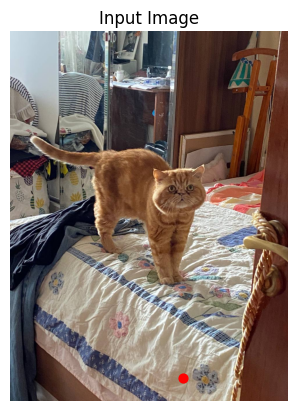

In [20]:

image = cv2.imread("Лева2.jpg")  # замени на свой путь
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)
plt.imshow(image)
plt.scatter([600], [1200], color='red', s=40)  # x, y
plt.title("Input Image")
plt.axis("off")
plt.show()


In [13]:
image.shape

(1280, 960, 3)

### ☝️ Сегментация по точке

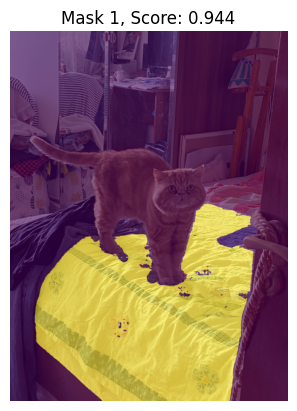

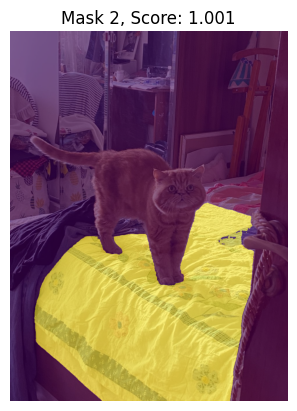

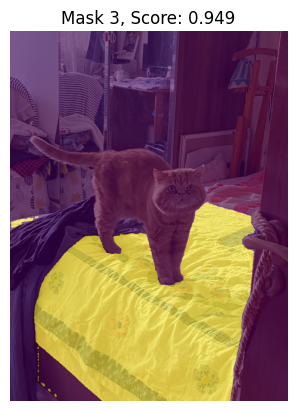

In [22]:

input_point = np.array([[600, 1200]])  # координаты точки
input_label = np.array([1])  # 1 — foreground, 0 — background

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True
)

for i, mask in enumerate(masks):
    plt.figure()
    plt.imshow(image)
    plt.imshow(mask, alpha=0.6)
    plt.title(f"Mask {i+1}, Score: {scores[i]:.3f}")
    plt.axis("off")
    plt.show()


### ☝️ Сегментация по контуру

### 📷 Загрузка изображения и подготовка

(793, 1280, 3)


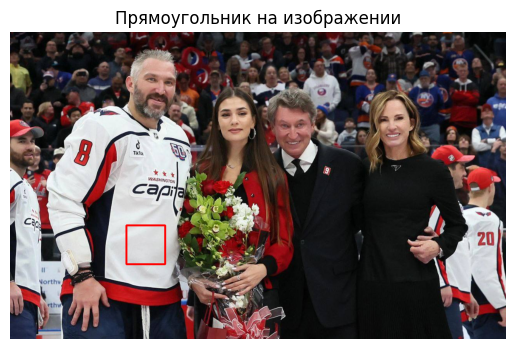

In [30]:
image = cv2.imread("Foto_Ovechkin.jpg")  # замени на свой путь
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)
# Координаты прямоугольника: (x1, y1) — левый верх, (x2, y2) — правый нижний
x1, y1 = 300, 500
x2, y2 = 400, 600
# Копируем изображение и рисуем прямоугольник
image_with_box = image.copy()
cv2.rectangle(image_with_box, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=3)  # красный прямоугольник
predictor.set_image(image)
# Показываем
plt.imshow(image_with_box)
plt.title("Прямоугольник на изображении")
plt.axis("off")
plt.show()

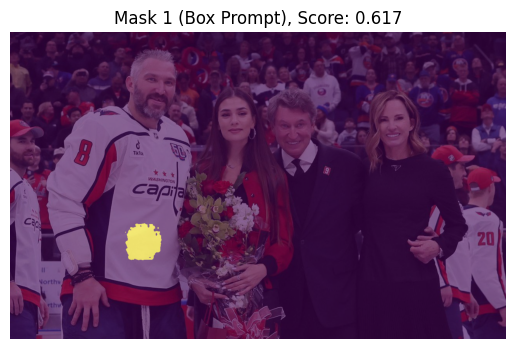

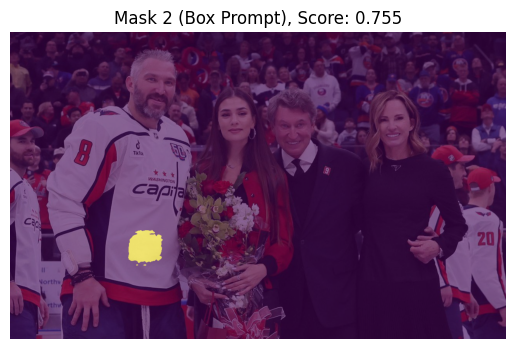

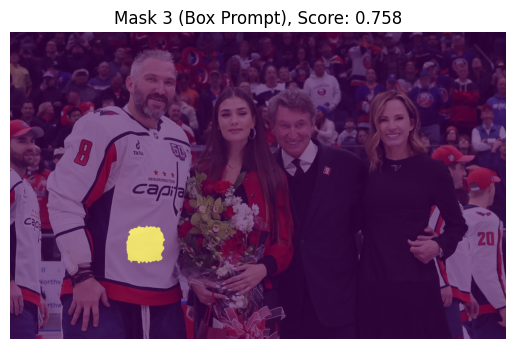

In [31]:

# Прямоугольный prompt
input_box = np.array([300, 500, 400, 600])  # [x1, y1, x2, y2]

# Передаём в SAM
masks, scores, logits = predictor.predict(
    box=input_box[None, :],  # обязательно батч
    multimask_output=True
)

# Визуализация масок
for i, mask in enumerate(masks):
    plt.figure()
    plt.imshow(image)
    plt.imshow(mask, alpha=0.6)
    plt.title(f"Mask {i+1} (Box Prompt), Score: {scores[i]:.3f}")
    plt.axis("off")
    plt.show()




## 🧪 Мини-OpenCV: работа с маской

После получения маски через SAM можно обработать её с помощью OpenCV.

### Примеры:
1. Извлечение контура:
```python
contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
```

2. Поиск bounding box:
```python
x, y, w, h = cv2.boundingRect(contours[0])
cv2.rectangle(image, (x, y), (x+w, y+h), (0,255,0), 2)
```

3. Вычисление площади и периметра:
```python
area = cv2.contourArea(contours[0])
perimeter = cv2.arcLength(contours[0], True)
```

4. Поиск центра массы:
```python
M = cv2.moments(contours[0])
cx = int(M["m10"] / M["m00"])
cy = int(M["m01"] / M["m00"])
```


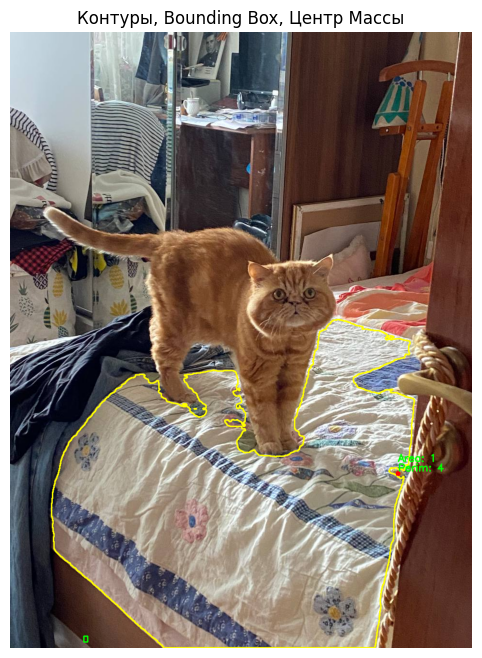

In [26]:
# Выбираем, например, первую маску
mask = masks[0]

# Находим контуры
contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Копируем изображение для отрисовки
image_copy = image.copy()

# Контур
cv2.drawContours(image_copy, contours, -1, (255, 255, 0), 2)

# Bounding box
x, y, w, h = cv2.boundingRect(contours[0])
cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Центр массы
M = cv2.moments(contours[0])
if M["m00"] != 0:
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    cv2.circle(image_copy, (cx, cy), 5, (255, 0, 0), -1)
else:
    cx, cy = -1, -1  # центр не определён

# Площадь и периметр
area = cv2.contourArea(contours[0])
perimeter = cv2.arcLength(contours[0], True)

# Добавим подписи
cv2.putText(image_copy, f"Area: {area:.0f}", (x, y - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
cv2.putText(image_copy, f"Perim: {perimeter:.0f}", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

# Визуализация
plt.figure(figsize=(8, 8))
plt.imshow(image_copy)
plt.title("Контуры, Bounding Box, Центр Массы")
plt.axis("off")
plt.show()


## 🧠 Что такое mask logits?

### 🔹 Определение:
**Logits** — это *сырые предсказания модели* до применения функции активации, такой как **сигмоида** (для бинарной классификации) или **софтмакс** (для многоклассовой).

В контексте **SAM**, logits — это **float-маска**: значения не ограничены [0, 1], и показывают **уверенность модели в принадлежности пикселя к объекту**. Чем выше значение — тем выше вероятность.

---

### 📊 Формально:

Если модель предсказывает бинарную маску:

$$
z in mathbb{R}
$$

Итоговая вероятность:

$$
hat{y} = sigma(z) = 1/(1 + e^{-z})
$$

- ( z ) — logit (предсказание до сигмоиды),
- ( hat{y} in (0, 1) ) — вероятность принадлежности пикселя.

---

### 📌 Применение:
- Можно **визуализировать logits** как тепловую карту.
- Можно применить **любой порог бинаризации**:
```python
binary_mask = (logits[0] > 0.0).astype(np.uint8)


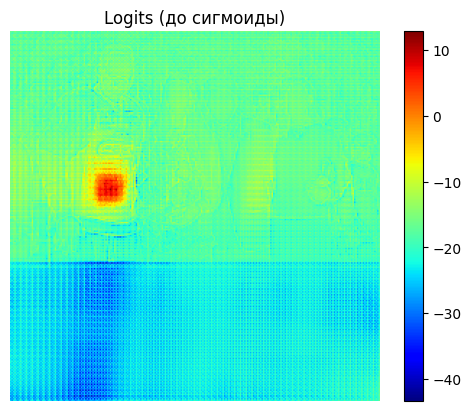

In [32]:
plt.imshow(logits[0], cmap="jet")
plt.colorbar()
plt.title("Logits (до сигмоиды)")
plt.axis("off")
plt.show()



---  
✅ После выполнения практики обязательно:
- Протестируй работу с прямоугольником (`input_box`)
- Попробуй с несколькими точками (positive и negative)
- Получи mask logits, применяй пороги и post-processing через OpenCV



## 📐 Упражнение по алгебре: собственные вектора и SAM

Рассмотрим матрицу внимания \( A = QK^T / \sqrt{d_k} \), где Q и K — эмбеддинги.

**Задача:**
1. Возьми сгенерированную матрицу эмбеддингов изображения (например, shape: (256, 64)) — сымитируй случайной матрицей.
2. Построй матрицу ковариации и найди собственные вектора:
```python
X = np.random.randn(256, 64)
cov = X.T @ X
eigenvalues, eigenvectors = np.linalg.eig(cov)
```

3. Отобрази несколько собственных векторов в виде изображений (reshaped patches).

**Цель:** понять, какие паттерны внимания "предпочитает" модель.

Это помогает:
- визуализировать главные направления в признаках,
- приблизиться к принципам PCA и self-attention.


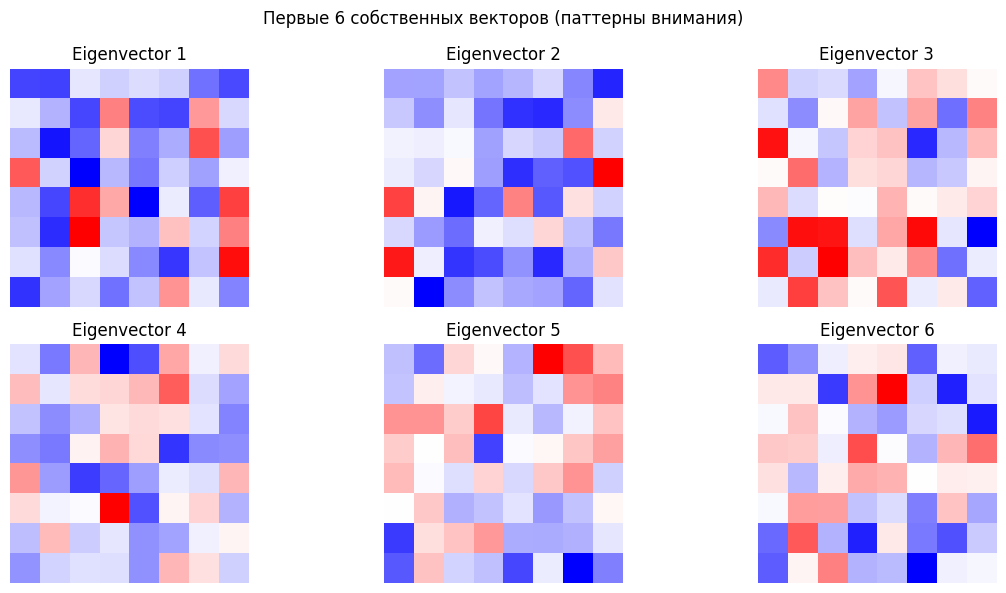

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Случайная матрица эмбеддингов (например, 256 патчей, 64 признака на патч)
X = np.random.randn(256, 64)  # (num_patches, embedding_dim)

# 2. Ковариационная матрица (приближение QK^T)
cov = X.T @ X  # shape: (64, 64)

# 3. Собственные значения и вектора
eigenvalues, eigenvectors = np.linalg.eig(cov)

# 4. Сортировка по убыванию значений
sorted_idx = np.argsort(-eigenvalues)
eigenvalues = eigenvalues[sorted_idx]
eigenvectors = eigenvectors[:, sorted_idx]

# 5. Визуализация первых 6 собственных векторов как "паттернов"
plt.figure(figsize=(12, 6))
for i in range(6):
    vec = eigenvectors[:, i]  # shape: (64,)
    patch = vec.reshape(8, 8)  # представим как 8x8 патч (если embedding_dim = 64)
    plt.subplot(2, 3, i+1)
    plt.imshow(patch, cmap="bwr", interpolation="nearest")
    plt.title(f"Eigenvector {i+1}")
    plt.axis("off")
plt.suptitle("Первые 6 собственных векторов (паттерны внимания)")
plt.tight_layout()
plt.show()
